# Boat Navigation Project
### **authors**: Justinas Smertinas
### **email**: justinas.smertinas@gmail.com  
### **date**: January 22nd 2022  

For now there is just some basic things in this notebook. I use it as template to test stuff.

### Importing the stuff we need

In [10]:
import numpy as np 
import scipy
from scipy.io import loadmat
import scipy.optimize  as sp
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import random
from math import sqrt

### Loading the Data

In [11]:
annots = loadmat('Maps/Vombsjon.mat')
depth = annots["Depth"]
#yN = annots["yN"] 
depth = depth.T # sometimes we transpose, because it looks better that way.

depth.shape

(100, 200)

### Defining/Importing a function to make animations

This function makes animations of simulations and saves them as *gif*s.

In [12]:
from make_animation import make_animation

### Defining/Importing the Move functions

##### Random Move:
Moves one step in random direction, except for when the depth is under 1m, then we stay and wait for a direction to move away.

##### DVD Move:
Kinda moves like a DVD logo on the screen saver. Bounces around the map.

In [13]:
from move_random import move_random
from move_DVD import move_DVD

### Defining/Importing different weight updating schemes

#### 1. basic_weights() - The one we make together.

#### 2. improved_weights() - Here, we also account for the movement of the boat with compass.
Here we compare the *change in depth* and *how close the depth is* to current boat location. We compare the change in depth by for each particle making a backwards step, checking the depth there, taking a difference, and then evaluating pdf on that. Then multiply by basic weights. Hope this rough outline makes sense.

In [14]:
from weights_basic import weights_basic
from weights_improved import weights_improved

### Defining/Importing different particle initialisastion schemes

#### 1. uniform random distributed

#### 2. uniform grid distributed

In [15]:
from particles_grid import particles_grid
from particles_unif import particles_unif

### Simple function to compute distances between *true location* and *estimated location* at each step

In [16]:
def distances(particlesX, particlesY, truePosX, truePosY, weights=None):
    if weights is None:
        guessesX = np.average(np.array(particlesX), axis=1)
        guessesY = np.average(np.array(particlesY), axis=1)
    else:
        guessesX = np.average(np.array(particlesX), axis=1, weights = weights)
        guessesY = np.average(np.array(particlesY), axis=1, weights = weights)

    return np.sqrt((truePosX - guessesX)**2 + (truePosY - guessesY)**2)

## Here we start testing the different approaches

### Setting up particles

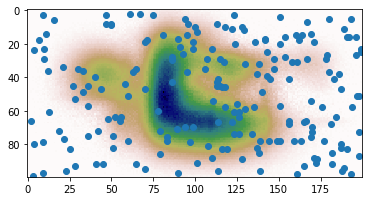

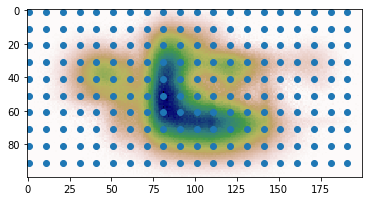

In [17]:
# Number of particles 
K = 200 

unif_x, unif_y = particles_unif(depth, K) 
grid_x, grid_y = particles_grid(depth, 10)

plt.figure()  
plt.imshow(depth, cmap='gist_earth', interpolation='nearest')
plt.scatter(unif_x, unif_y)
plt.show()
plt.show()

plt.figure()  
plt.imshow(depth, cmap='gist_earth', interpolation='nearest')
plt.scatter(grid_x, grid_y)
plt.show()
plt.show()

### Make a simple simulation (for playing around)

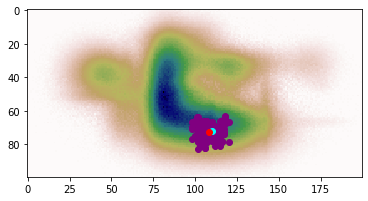

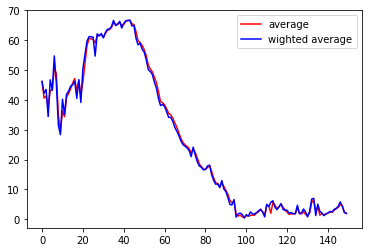

In [47]:
############
# Settings #
############

# Number of particles 
K = 420 

# Number of steps in Monte-Carlo simulation
N = 150

# Which schemes to use
particles_init = 'grid'
weights_setting = 'basic'
moves_setting = 'DVD'

# Initial direction
direction = [1, 1]


#####################
# Actual Simulation #
#####################

# Particle Initialisation
if particles_init == 'grid':
    particles_x, particles_y = particles_grid(depth, 10) 
elif particles_init == 'unif':
    particles_x, particles_y = particles_unif(depth, K)

K = len(particles_x)

# temporary weights array
we = np.ones(len(particles_x))

# Some lists for storing 
animatedWeights = []
animatedParticlesx = []
animatedParticlesy = []

animatedWeights.append(we)
animatedParticlesx.append(particles_x)
animatedParticlesy.append(particles_y)

truePositionx = np.zeros(N)
truePositiony = np.zeros(N)

truePositionx[0] = 50
truePositiony[0] = 50

for i in range(1,N):

    # weighting
    if weights_setting == 'basic':
        we = weights_basic(truePositionx,truePositiony, particles_x, particles_y, i, map = depth)
    elif weights_setting == 'improved':
        we = weights_improved(truePositionx,truePositiony, particles_x, particles_y, direction, i, map = depth)


    # moving
    if moves_setting == 'random':
        truePositionx[i], truePositiony[i], direction = move_random([truePositionx[i-1], truePositiony[i-1]], depth)
    elif moves_setting == 'DVD':
        truePositionx[i], truePositiony[i], direction = move_DVD([truePositionx[i-1], truePositiony[i-1]], direction, depth)

    Index = range(K)

    Index = random.choices(Index, weights =we, k = K)

    we = we[Index]

    particles_x = particles_x[Index]
    particles_y = particles_y[Index]

    propspread = 4
    particles_x = particles_x + direction[0]*np.ones(len(particles_x)).astype(int) + np.random.binomial(propspread, 0.5,size = K) - np.random.binomial(propspread, 0.5,size = K)
    particles_y = particles_y + direction[1]*np.ones(len(particles_y)).astype(int) + np.random.binomial(propspread, 0.5,size = K) - np.random.binomial(propspread, 0.5,size = K)

    animatedWeights.append(we)
    animatedParticlesx.append(particles_x)
    animatedParticlesy.append(particles_y)


xguess = np.average(particles_x, axis=None, weights=we, returned=False)
yguess = np.average(particles_y, axis=None, weights=we, returned=False)
    
plt.imshow(depth, cmap='gist_earth', interpolation='nearest')

plt.scatter(particles_x,particles_y, color = 'purple')
plt.scatter(truePositionx[N-1],truePositiony[N-1],color ="cyan")
plt.scatter(xguess,yguess,color ="red")
plt.show()

distance_array = distances(animatedParticlesx, animatedParticlesy, truePositionx, truePositiony)
distance_waighted_array = distances(animatedParticlesx, animatedParticlesy, truePositionx, truePositiony, weights=animatedWeights)
plt.figure()
plt.plot(distance_array, color = 'red', label = 'average')
plt.plot(distance_waighted_array, color = 'blue', label = 'wighted average')
plt.legend()
plt.show()

### Create animation of this simulation in working directory

animation started


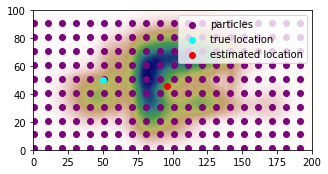

saving gif
Done animating, gif saved, xoxo


0

In [23]:
make_animation(animatedParticlesx, animatedParticlesy, truePositionx, truePositiony, weights = animatedWeights, background_image = depth, filename='simulation_grid.gif')


### Fuction to do many simulations and plot average distance change.

#### Set-up:
* Run the boat-locating simulation **nrun** times, each runs for **nstep** steps, where we use **npart** number of particles.
* Calculate differences between **true position** and **guessed position** at each step.
* Add total differences divide by number of runs.
* Return the rusults

In [48]:
def average_basic_runs(nrun=1000, nstep = 300, npart = 300, start=None, weights='improved', moves='DVD', init='grid', spread = 5, spacing = 5, verbose=False):

    dist_array = np.zeros(nstep)
    dist_weighted_array = np.zeros(nstep)

    direction = [1,1] # We start by heading north-east, for consistency.


    # Just initialising some particles, so we know how many weights to use and such.
    # Plus helpful to know is comparing different schemes e.g. making sure number of particles between grid and unif schemes is the same.
    if init == 'grid':
        particlesx, particlesy = particles_grid(depth, spacing=spacing) 
    elif init == 'unif':
        particlesx, particlesy = particles_unif(depth, npart)
    print('Using ' + str(len(particlesx)) + " particles, let's go!")



    for run in range(nrun):
        
        # Printing run number every 20% of runs done
        if verbose:
            if run % round(nrun*0.2) == 0:
                print(run)
        
        if init == 'grid':
            particlesx, particlesy = particles_grid(depth, spacing=spacing) 
        elif init == 'unif':
            particlesx, particlesy = particles_unif(depth, npart)

        # Number of particles 
        partN = len(particlesx)

        w = np.ones(partN)

        logWeights = []
        logParticlesx = []
        logParticlesy = []

        logWeights.append(w)
        logParticlesx.append(particlesx)
        logParticlesy.append(particlesy)

        #Number of steps in Monte-Carlo simulation
        N = nstep


        # Setting starting position
        #--------------------------
        truePositionX = np.zeros(N)
        truePositionY = np.zeros(N)

        # If we put nothing, then start is random
        if start is None:
            truePositionX[0] = np.random.randint(1,199)
            truePositionY[0] = np.random.randint(1,99)
            while (depth[int(truePositionY[0]), int(truePositionX[0])] >= -1):
                truePositionX[0] = np.random.randint(2,198)
                truePositionY[0] = np.random.randint(2,98)

        else:
            truePositionX[0] = int(start[0])
            truePositionY[0] = int(start[1])


        # Updating particles
        #-------------------
        for i in range(1,N):
            
            # weighting
            if weights == 'basic':
                w = weights_basic(truePositionX,truePositionY, particlesx, particlesy, i, map = depth)
            elif weights == 'improved':
                w = weights_improved(truePositionX,truePositionY, particlesx, particlesy, direction, i, map = depth)
            # moving
            if moves == 'random':
                truePositionX[i], truePositionY[i], direction = move_random([truePositionX[i-1], truePositionY[i-1]], depth)
            elif moves == 'DVD':
                truePositionX[i], truePositionY[i], direction = move_DVD([truePositionX[i-1], truePositionY[i-1]], direction, depth)

            Ind = range(partN)

            Ind = random.choices(Ind, weights = w, k = partN)

            w = w[Ind]

            particlesx = particlesx[Ind]
            particlesy = particlesy[Ind]

            propspread = spread
            particlesx = particlesx + direction[0]*np.ones(partN).astype(int) + np.random.binomial(propspread, 0.5,size = partN) - np.random.binomial(propspread, 0.5,size = partN)
            particlesy = particlesy + direction[1]*np.ones(partN).astype(int) + np.random.binomial(propspread, 0.5,size = partN) - np.random.binomial(propspread, 0.5,size = partN)

            logParticlesx.append(particlesx)
            logParticlesy.append(particlesy)
            logWeights.append(w)

        dist_array = dist_array + distances(logParticlesx, logParticlesy, truePositionX, truePositionY)
        dist_weighted_array = dist_weighted_array + distances(logParticlesx, logParticlesy, truePositionX, truePositionY, weights=logWeights)

    plt.figure()
    plt.plot(dist_array/nrun, color = 'red', label = 'average')
    plt.plot(dist_weighted_array/nrun, color = 'blue', label = 'wighted average')
    plt.legend()
    plt.show()

    return dist_array/nrun, dist_weighted_array/nrun


### Testing Grid vs. Unif random particle initialisation

Simulating: Improved + DVD + Grid 10
Using 200 particles, let's go!


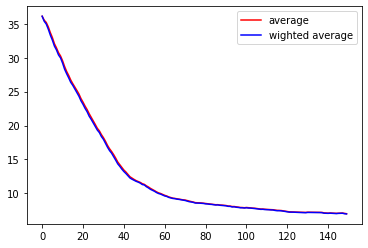


Simulating: Improved + DVD + Unif
Using 200 particles, let's go!


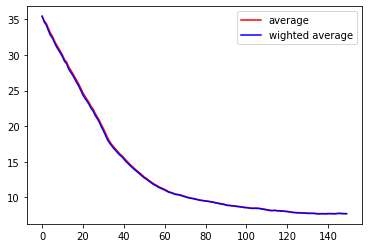

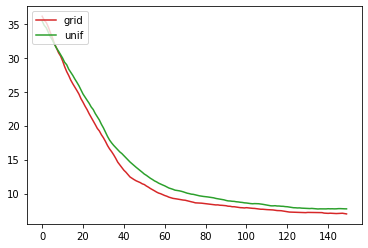

In [53]:
print('Simulating: Improved + DVD + Grid 10')
agg_1, agg_1_w = average_basic_runs(nrun= 1000, nstep = 150, npart = 200, start=None, verbose=False, weights='improved', moves='DVD', init = 'grid', spread = 5, spacing = 10)
print()

print('Simulating: Improved + DVD + Unif')
agg_2, agg_2_w = average_basic_runs(nrun= 1000, nstep = 150, npart = 200, start=None, verbose=False, weights='improved', moves='DVD', init = 'unif', spread = 5, spacing = 10)
print()

comb_fig = plt.figure()
ax = comb_fig.add_subplot(1,1,1)
ax.plot(agg_1, color='tab:red', label='grid')
ax.plot(agg_2, color='tab:green',label='unif')
ax.legend(loc='upper left')